In [10]:
import json
import threading
import json
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import timeit
from PIL import Image

from urllib.request import urlopen
from sklearn.preprocessing import MultiLabelBinarizer

from keras.callbacks import ModelCheckpoint   
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D

DATA_DIR = "../data/"
NUM_CLASSES = 228
IMAGE_SIZE = 128

In [2]:
with open(DATA_DIR + "train.json") as train, open(DATA_DIR + "test.json") as test, open(DATA_DIR + "validation.json") as validation:
    train_json = json.load(train)
    test_json = json.load(test)
    validation_json = json.load(validation)
    

train_urls = [obj['url'] for obj in train_json['images']]
test_urls = [obj['url'] for obj in test_json['images']]
validation_urls = [obj['url'] for obj in validation_json['images']]

print(train_urls[:3])
print(test_urls[:3])
print(validation_urls[:3])

['https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large', 'https://contestimg.wish.com/api/webimage/5468f1c0d96b290ff8e5c805-large', 'https://contestimg.wish.com/api/webimage/546410237d57f323e72ca414-large']
['https://contestimg.wish.com/api/webimage/568e16a72dfd0133cb3f7a79-large', 'https://contestimg.wish.com/api/webimage/5452f9925f313f502bf119ff-large', 'https://contestimg.wish.com/api/webimage/540584051d2d435c5a300a82-large']
['https://contestimg.wish.com/api/webimage/568e16a72dfd0133cb3f7a79-large', 'https://contestimg.wish.com/api/webimage/5452f9925f313f502bf119ff-large', 'https://contestimg.wish.com/api/webimage/540584051d2d435c5a300a82-large']


In [3]:
def generate_label_array(json_obj):
    result = []
    for data in json_obj['annotations']:
        temp_array = [0] * NUM_CLASSES
        for elem in data['labelId']:
            temp_array[int(elem) - 1] = 1
        result.append(temp_array)
    return np.array(result)

train_labels = generate_label_array(train_json)
validation_labels = generate_label_array(validation_json)

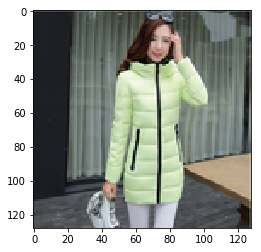

In [4]:
TARGET_SIZE=(IMAGE_SIZE,IMAGE_SIZE)

rand_img = np.random.randint(0, len(train_urls))
img_label = np.array(train_labels[rand_img]).reshape(1, 228)
img_path = train_urls[rand_img]
img_file = urlopen(img_path)
image = Image.open(img_file)
image_resized = image.resize(TARGET_SIZE, Image.ANTIALIAS)
image_resized.thumbnail(TARGET_SIZE, Image.ANTIALIAS)
plt.imshow(np.asarray(image_resized))
plt.show()

In [13]:
class BatchGenerator:
    def __init__(self, img_array, label_array, batch_size=32, target_size=(IMAGE_SIZE,IMAGE_SIZE)):
        self.img_array = img_array
        self.label_array = label_array
        self.batch_size = batch_size
        self.lock = threading.Lock()
        self.TARGET_SIZE=target_size
        
    def __iter__(self):
        return self
    
    def next(self):
        return self.__next__()
    
# data = np.empty((N, 3, 256, 256), dtype=np.uint8)
# for i, fpath in enumerate(fpaths):
# img = cv2.imread(fpath, cv2.CV_LOAD_IMAGE_COLOR)
# data[i, ...] = img.transpose(2, 0, 1)

    def __next__(self):
        with self.lock:
            while True:
                X = []
                y = []
                for i in range(self.batch_size):
                    rand_img = np.random.randint(0, len(self.img_array))
                    img_label = np.array(self.label_array[rand_img]).reshape(1, NUM_CLASSES)
                    img_path = self.img_array[rand_img]
                    image = self.url_to_image(img_path)
                    X_batch = np.asarray(image).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
                    X_batch = X_batch / 255.0
                    X.append(X_batch)
                    y.append(img_label)
                return np.array(X).reshape(self.batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), np.array(y).reshape(self.batch_size, NUM_CLASSES)
                
            
    def url_to_image(self, url):
        try:
            resp = urllib.urlopen(url)
            image = np.asarray(bytearray(resp.read()), dtype='uint8')
            image = cv2.imdecode(image, cv2.IMREAD_COLOR)
        except:
            output = [1]*(IMAGE_SIZE*IMAGE_SIZE*3)
            output = np.array(output).reshape(IMAGE_SIZE,IMAGE_SIZE,3).astype('uint8')
            image = Image.fromarray(output).convert('RGB')
        image_resized = image.resize(self.TARGET_SIZE, Image.ANTIALIAS)
        image_resized.thumbnail(self.TARGET_SIZE, Image.ANTIALIAS)
        return image_resized
       

In [34]:
class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        return next(self.it)

    def next(self):     # Py2
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """
    A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

@threadsafe_generator
def test_generator(img_array, label_array, batch_size=32, target_size=(IMAGE_SIZE,IMAGE_SIZE)):  
    while True:
        X = []
        y = []
        for i in range(batch_size):
            rand_img = np.random.randint(0, len(img_array))
            img_label = np.array(label_array[rand_img]).reshape(1, NUM_CLASSES)
            img_path = img_array[rand_img]
            image = url_to_image(img_path, target_size)
            X_batch = np.asarray(image).reshape(1, IMAGE_SIZE, IMAGE_SIZE, 3)
            X_batch = X_batch / 255.0
            X.append(X_batch)
            y.append(img_label)
        yield np.array(X).reshape(batch_size, IMAGE_SIZE, IMAGE_SIZE, 3), np.array(y).reshape(batch_size, NUM_CLASSES)

def url_to_image(url, target_size):
    try:
        resp = urllib.urlopen(url)
        image = np.asarray(bytearray(resp.read()), dtype='uint8')
        image = cv2.imdecode(image, cv2.IMREAD_COLOR)
    except:
        output = [1]*(IMAGE_SIZE*IMAGE_SIZE*3)
        output = np.array(output).reshape(IMAGE_SIZE,IMAGE_SIZE,3).astype('uint8')
        image = Image.fromarray(output).convert('RGB')
    image_resized = image.resize(target_size, Image.ANTIALIAS)
    image_resized.thumbnail(target_size, Image.ANTIALIAS)
    return image_resized

In [37]:
BATCH = 100
# train_gen = BatchGenerator(train_urls, train_labels, batch_size = BATCH)
train_gen2 = BatchGenerator2(train_urls, train_labels, batch_size = BATCH)
train_gen3 = test_generator(train_urls, train_labels, batch_size = BATCH)

# next(train_gen)
# print(timeit.timeit(lambda: train_gen.next()))
# print(timeit.timeit(lambda: train_gen2.next()))
# print(timeit.timeit(lambda: next(train_gen3)))
# print(timeit.timeit(lambda: next(BatchGenerator2(train_urls, train_labels, batch_size = BATCH_SIZE))))

(array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157]],

        ...,

        [[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157

In [41]:
model = Sequential()
model.add(Conv2D(filters=30, kernel_size=3, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.3))
model.add(Dense(30, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(228, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 30)      840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 126, 126, 30)      0         
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 30)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 30)                930       
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 228)               7068      
Total para

In [45]:
EPOCHS = 1
BATCH_SIZE = 10000
STEPS = len(train_urls) // BATCH_SIZE

# train_gen = BatchGenerator(train_urls, train_labels)
# val_gen = BatchGenerator(validation_urls, validation_labels)

train_gen = test_generator(train_urls, train_labels, batch_size = BATCH)
val_gen = test_generator(validation_urls, validation_labels, batch_size = BATCH)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

checkpointer = ModelCheckpoint(
    filepath='model.best.hdf5', 
    verbose=1,
    save_best_only=True
)

history = model.fit_generator(
    generator = train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    steps_per_epoch = STEPS,
    validation_steps = 1,
)

Epoch 1/1
101/101 [==============================] - 167s 2s/step - loss: 28.2502 - acc: 0.1302 - val_loss: 36.5992 - val_acc: 0.0300
